#rows=27820 #columns=12


(array([2.2848e+04, 3.3060e+03, 8.5900e+02, 5.0600e+02, 1.9400e+02,
        7.3000e+01, 1.6000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00]),
 array([  0.   ,  22.497,  44.994,  67.491,  89.988, 112.485, 134.982,
        157.479, 179.976, 202.473, 224.97 ]),
 <BarContainer object of 10 artists>)

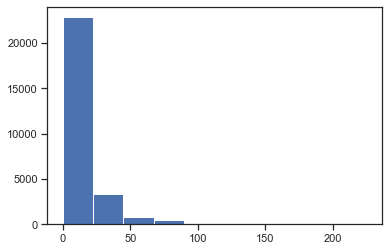

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# load the data file
dfOrg = pd.read_csv('s_rates.csv')
print(f'#rows={len(dfOrg)} #columns={len(dfOrg.columns)}')

#print(dfOrg.dtypes)

#print(dfOrg.head())

plt.hist(dfOrg['suicides/100k pop'])


(array([8., 4., 2., 3., 2., 5., 3., 1., 2., 2.]),
 array([11.01146368, 11.4765844 , 11.94170513, 12.40682585, 12.87194658,
        13.33706731, 13.80218803, 14.26730876, 14.73242949, 15.19755021,
        15.66267094]),
 <BarContainer object of 10 artists>)

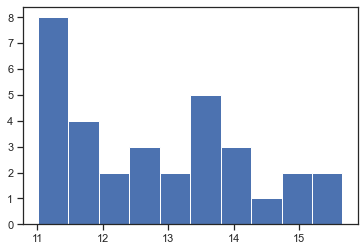

In [2]:
df_year = dfOrg.groupby(['year']).mean()

#print(df_year)

plt.hist(df_year['suicides/100k pop'])

(array([21., 21., 16., 15.,  7., 10.,  4.,  3.,  3.,  1.]),
 array([ 0.        ,  4.04155725,  8.0831145 , 12.12467176, 16.16622901,
        20.20778626, 24.24934351, 28.29090076, 32.33245802, 36.37401527,
        40.41557252]),
 <BarContainer object of 10 artists>)

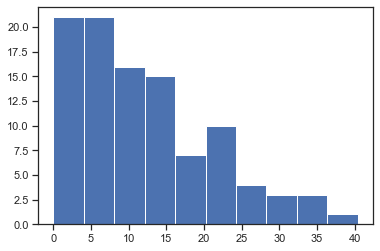

In [3]:
df_country = dfOrg.groupby(['country']).mean()

#print(df_country)

plt.hist(df_country['suicides/100k pop'])

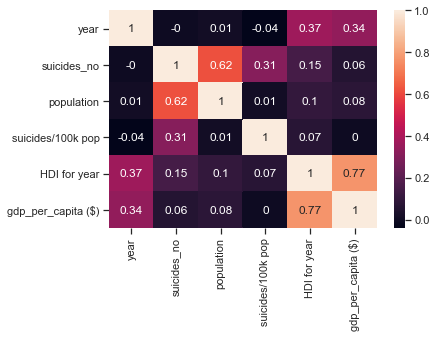

In [4]:
matrix = dfOrg.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

1) Use your previous pre-processed dataset, keep the variables as one-hot encoded
    and develop a multiple linear regression model. Use your model to predict the target
    variable for the people with age 20, male, and generation X. What is the MAE error of this
    prediction? How many regression coefficients are there?

In [5]:
def encode_onehot (_df, _f_target):
    ___df = _df.copy()
    # Convert all features of type object to one-hot encoded with pandas dummies
    for f in list(_df.columns.values):
        if _df[f].dtype == object:
            if f == _f_target:
                # recurrence is the target variable and will be treated differently
                continue

            __df = pd.get_dummies(_df[f], prefix='',
                                  prefix_sep='').groupby(level=0, axis=1).max().add_prefix(f+' - ')
            _df = pd.concat([_df, __df], axis=1)
            _df = _df.drop([f], axis=1)

    return _df

df_1 = dfOrg.copy()
df_1['HDI for year'] = df_1['HDI for year'].fillna(df_1['HDI for year'].mean())
df_1 = df_1.drop(columns=['population', ' gdp_for_year ($) ', 'gdp_per_capita ($)','country-year','year','country']).copy()

df_1 = encode_onehot(df_1, '')

df_1 = df_1[(df_1["generation - Generation X"] == 1)]
df_1 = df_1[(df_1["age - 15-24 years"] == 1)]
df_1 = df_1[(df_1["sex - male"] == 1)]
df_1 = df_1.loc[:, df_1.any()]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(df_1.head())

print(df_1.columns)


    suicides_no  suicides/100k pop  HDI for year  sex - male  \
0            21               6.71      0.776601           1   
13           17               5.33      0.776601           1   
28           12               3.71      0.776601           1   
37            9               3.41      0.776601           1   
48           18               7.40      0.776601           1   

    age - 15-24 years  generation - Generation X  
0                   1                          1  
13                  1                          1  
28                  1                          1  
37                  1                          1  
48                  1                          1  
Index(['suicides_no', 'suicides/100k pop', 'HDI for year', 'sex - male',
       'age - 15-24 years', 'generation - Generation X'],
      dtype='object')


In [6]:
from sklearn.preprocessing import LabelEncoder


ytemp = df_1['suicides/100k pop'].values
y_mean = np.mean(ytemp)
y_std = np.std(ytemp)

target_new = pd.cut(df_1['suicides/100k pop'], bins = [np.NINF, (y_mean+0.5*y_std), np.Infinity], labels=["Low", "High"])

X = df_1.loc[:, df_1.columns != 'suicides/100k pop'].values
y = target_new.values
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

np.warnings.filterwarnings('ignore')

clf = LogisticRegression(random_state=None, solver='sag', max_iter=10000)
clf.fit(MinMaxScaler().fit_transform(X), y)
coef = clf.coef_[0]

clf_pipeline = Pipeline([['scaler', MinMaxScaler()], ['clf', clf]])
scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring='accuracy')

print(f'accuracy mean,stdev= {scores.mean():.2f},{scores.std():.2f}\n')

# print the coefficients
print(clf.intercept_)
print(clf.coef_)

print('Order of Regression Weights:')
print('Weight   Feature')
for i in reversed(np.argsort(np.abs(coef))):
    print(f'{np.abs(coef[i]):.3f}    {df_1.columns[i]}')

mae = cross_val_score(estimator=clf, X=X, y=y, cv=10,scoring='neg_mean_absolute_error')
print(mae[0])

accuracy mean,stdev= 0.77,0.03

[2.10732111]
[[-2.96700028 -1.25252171  0.          0.          0.        ]]
Order of Regression Weights:
Weight   Feature
2.967    suicides_no
1.253    suicides/100k pop
0.000    age - 15-24 years
0.000    sex - male
0.000    HDI for year
-0.24528301886792453


1) There are 5 line coefficients and the accuracy is 77%. The MAE is -0.24528302.

2) Now use the original sex, age and generation variables in numerical form and
    develop a new model. Use your model to predict the target value for the people with age
    20, male, and generation X. What is the MAE error of this prediction? How many line
    coefficients are there? (Note that for this step you have to think of a way of encoding the
    original nominal age feature and generation feature into numerical features.)

In [8]:
df = dfOrg.copy()
df['sex'] = df['sex'].replace({
'female':0,
'male':1})
df['age'] = df['age'].replace({
'5-14 years':10,
'15-24 years':20,
'25-34 years':30,
'35-54 years':45,
'55-74 years':65,
'75+ years':80})
df['generation'] = df['generation'].replace({
'G.I. Generation':1,
'Silent':2,
'Boomers':3,
'Generation X':4,
'Millenials':5,
'Generation Z':6})
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,1,20,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,4
1,Albania,1987,1,45,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,2
2,Albania,1987,0,20,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,4
3,Albania,1987,1,80,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,1
4,Albania,1987,1,30,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,3


In [9]:
df['HDI for year'] = df['HDI for year'].fillna(df['HDI for year'].mean())
df = df[(df["generation"] == 4)]
df = df[(df["age"] == 20)]
df = df[(df["sex"] == 1)]


ytemp = df['suicides/100k pop'].values
y_mean = np.mean(ytemp)
y_std = np.std(ytemp)

target_new = pd.cut(df['suicides/100k pop'], bins = [np.NINF, (y_mean+0.5*y_std), np.Infinity], labels=["Low", "High"])

df = df.drop(columns=['population', ' gdp_for_year ($) ', 'gdp_per_capita ($)','country-year','year','country']).copy()

df.head()

,sex,age,suicides_no,suicides/100k pop,HDI for year,generation
0,1,20,21,6.71,0.776601,4
13,1,20,17,5.33,0.776601,4
28,1,20,12,3.71,0.776601,4
37,1,20,9,3.41,0.776601,4
48,1,20,18,7.40,0.776601,4


In [10]:
from sklearn.preprocessing import LabelEncoder
# Let's build a classifier, first populate X and y
X = df.loc[:, df.columns != 'suicides/100k pop'].values
y = target_new.values
le = LabelEncoder()
y = le.fit_transform(y)

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

np.warnings.filterwarnings('ignore')

clf = LogisticRegression(random_state=None, solver='sag', max_iter=10000)
clf.fit(MinMaxScaler().fit_transform(X), y)
coef = clf.coef_[0]

clf_pipeline = Pipeline([['scaler', MinMaxScaler()], ['clf', clf]])
scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring='accuracy')

print(f'accuracy mean,stdev= {scores.mean():.2f},{scores.std():.2f}\n')

# print the coefficients
print(clf.intercept_)
print(clf.coef_)

print('Order of Regression Weights:')
print('Weight   Feature')
for i in reversed(np.argsort(np.abs(coef))):
    print(f'{np.abs(coef[i]):.3f}    {df.columns[i]}')

mae = cross_val_score(estimator=clf, X=X, y=y, cv=10,scoring='neg_mean_absolute_error')
print(mae[0])

accuracy mean,stdev= 0.77,0.04

[2.10717862]
[[ 0.          0.         -2.96709198 -1.2524066   0.        ]]
Order of Regression Weights:
Weight   Feature
2.967    suicides_no
1.252    suicides/100k pop
0.000    HDI for year
0.000    age
0.000    sex
-0.24528301886792453


2) There are 5 line coefficients and the accuracy is 77%. The MAE is -0.24528302.

3) The models performance are both the same as the underlying data is identical and they are both using the Linear Regression technique with the same parameters.

4) What is the prediction for age 33, male and generation Alpha (i.e. the generation
    after generation Z)?

In [12]:
df = dfOrg.copy()
df['sex'] = df['sex'].replace({
'female':0,
'male':1})
df['age'] = df['age'].replace({
'5-14 years':10,
'15-24 years':20,
'25-34 years':30,
'35-54 years':45,
'55-74 years':65,
'75+ years':80})
df['generation'] = df['generation'].replace({
'G.I. Generation':1,
'Silent':2,
'Boomers':3,
'Generation X':4,
'Millenials':5,
'Generation Z':6})
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,1,20,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,4
1,Albania,1987,1,45,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,2
2,Albania,1987,0,20,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,4
3,Albania,1987,1,80,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,1
4,Albania,1987,1,30,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,3


In [13]:
df['HDI for year'] = df['HDI for year'].fillna(df['HDI for year'].mean())
df = df[(df["age"] == 30)]
df = df[(df["sex"] == 1)]


ytemp = df['suicides/100k pop'].values
y_mean = np.mean(ytemp)
y_std = np.std(ytemp)

target_new = pd.cut(df['suicides/100k pop'], bins = [np.NINF, (y_mean+0.5*y_std), np.Infinity], labels=["Low", "High"])

df = df.drop(columns=['population', ' gdp_for_year ($) ', 'gdp_per_capita ($)','country-year','year','country']).copy()

df.head()

,sex,age,suicides_no,suicides/100k pop,HDI for year,generation
4,1,30,9,3.28,0.776601,3
20,1,30,5,1.79,0.776601,3
25,1,30,18,6.35,0.776601,3
39,1,30,7,2.85,0.776601,3
51,1,30,9,3.91,0.776601,3


In [14]:
from sklearn.preprocessing import LabelEncoder
# Let's build a classifier, first populate X and y
X = df.loc[:, df.columns != 'suicides/100k pop'].values
y = target_new.values
le = LabelEncoder()
y = le.fit_transform(y)

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

np.warnings.filterwarnings('ignore')

clf = LogisticRegression(random_state=None, solver='sag', max_iter=10000)
clf.fit(MinMaxScaler().fit_transform(X), y)
coef = clf.coef_[0]

clf_pipeline = Pipeline([['scaler', MinMaxScaler()], ['clf', clf]])
scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring='accuracy')

print(f'accuracy mean,stdev= {scores.mean():.2f},{scores.std():.2f}\n')

# print the coefficients
print(clf.intercept_)
print(clf.coef_)

print('Order of Regression Weights:')
print('Weight   Feature')
for i in reversed(np.argsort(np.abs(coef))):
    print(f'{np.abs(coef[i]):.3f}    {df.columns[i]}')

mae = cross_val_score(estimator=clf, X=X, y=y, cv=10,scoring='neg_mean_absolute_error')
print(mae[0])

accuracy mean,stdev= 0.79,0.05

[1.10381657]
[[ 0.          0.         -3.29523165  0.25254179  0.45357763]]
Order of Regression Weights:
Weight   Feature
3.295    suicides_no
0.454    HDI for year
0.253    suicides/100k pop
0.000    age
0.000    sex
-0.21030042918454936


The prediction is 1.10379929 for age 33, male and generation Alpha.

5) One advantage when using regression as opposed to classification with
   nominal features in terms of input data features is that it outputs a real-valued variable and interperets
   model coefficients as feauture importance.

6) One advantage when using regular numerical values rather than one-hot
    encoding for regression is that it is faster to build and process the model since there may be less columns and 
    data points to work with.

7) Now that I developed both a classifier and a regression model for the problem in
    this assignment I suggest using a Classifier since it is more accurate and regression assumes linearity between
    the dependent variable and the independent variables which may cause inaccurate forecasts. It will be harder to obtain complex relationships using regression and using a neural network classifier for example is more robust and will outperform the regression.